In [1]:
import numpy as np
import pandas as pd
from time import time
from sklearn.datasets import load_breast_cancer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.ensemble import AdaBoostClassifier
import matplotlib.pyplot as plt

Loading breast cancer dataset...
Dataset shape: (569, 30)
Number of classes: 2
Class distribution: [212 357]


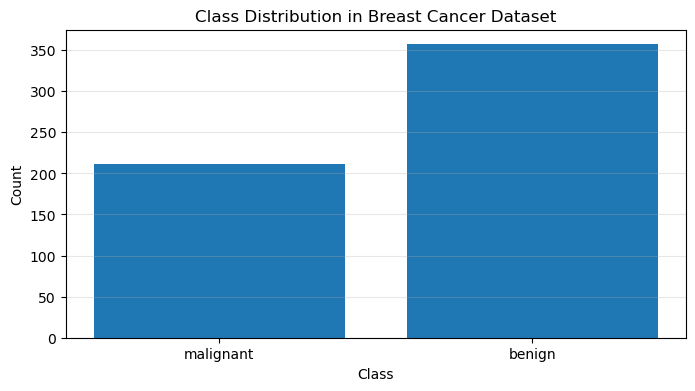

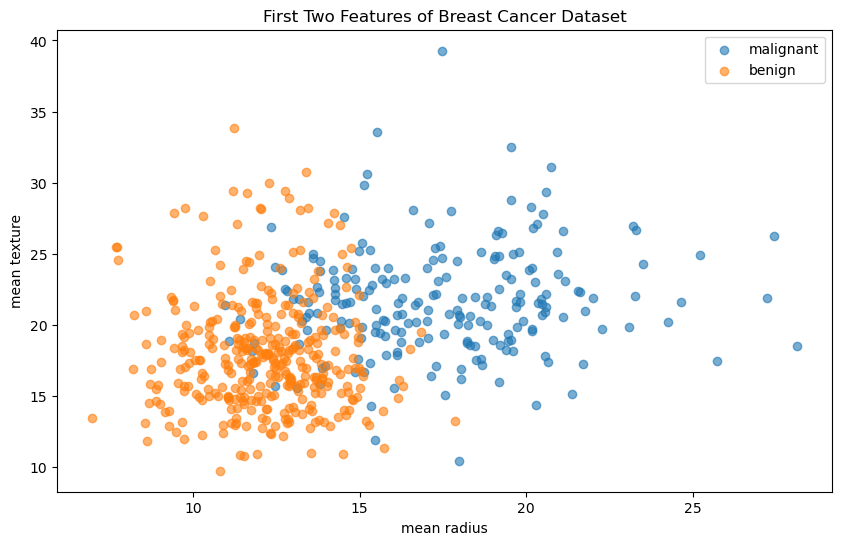

In [20]:
# Load breast cancer dataset
print("Loading breast cancer dataset...")
data = load_breast_cancer()
X = data.data
y = data.target
feature_names = data.feature_names
target_names = data.target_names

print(f"Dataset shape: {X.shape}")
print(f"Number of classes: {len(target_names)}")
print(f"Class distribution: {np.bincount(y)}")

# Plot class distribution
plt.figure(figsize=(8, 4))
plt.bar(target_names, np.bincount(y))
plt.title('Class Distribution in Breast Cancer Dataset')
plt.ylabel('Count')
plt.xlabel('Class')
plt.grid(axis='y', alpha=0.3)
plt.show()

# Visualize first two features
plt.figure(figsize=(10, 6))
for i, target in enumerate(np.unique(y)):
    plt.scatter(X[y==target, 0], X[y==target, 1], 
                label=target_names[i], alpha=0.6)
plt.xlabel(feature_names[0])
plt.ylabel(feature_names[1])
plt.title('First Two Features of Breast Cancer Dataset')
plt.legend()
plt.show()


In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
%pip install joblib

Note: you may need to restart the kernel to use updated packages.


In [ ]:
from joblib import Parallel, delayed

class CustomAdaBoost:
    def __init__(self, n_estimators=50, learning_rate=1.0, n_jobs=-1, min_accuracy=0.6):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.n_jobs = n_jobs  # -1 means use all available cores
        self.min_accuracy = min_accuracy 
        self.estimators = []
        self.estimator_weights = np.zeros(n_estimators)
        self.estimator_accuracies = []
        
    def _train_single_estimator(self, X, y_binary, sample_weights, i):
        """Train a single weak learner"""
        # Train a weak learner (stump) with current weights
        stump = DecisionTreeClassifier(max_depth=1)
        stump.fit(X, y_binary, sample_weight=sample_weights)
        
        # Make predictions
        pred = stump.predict(X)
        
        # Compute weighted error
        incorrect = (pred != y_binary)
        error = np.sum(sample_weights * incorrect) / np.sum(sample_weights)
        
        # Calculate accuracy of this weak learner
        accuracy = np.mean(pred == y_binary)
        
        # Early stopping if error is too large
        if error >= 0.5:
            return None, 0, 0
            
        # Compute estimator weight
        estimator_weight = self.learning_rate * np.log((1 - error) / max(error, 1e-10))
        
        return stump, estimator_weight, accuracy
        
    def fit(self, X, y):
        n_samples = X.shape[0]
        sample_weights = np.ones(n_samples) / n_samples
        
        # Classes must be {-1, 1} for AdaBoost algorithm
        y_binary = np.copy(y)
        y_binary[y_binary == 0] = -1
        
        self.estimators = []
        self.estimator_weights = []
        self.estimator_accuracies = []
        
        for i in range(self.n_estimators):
            # Train estimator and get weight
            stump, weight, accuracy = self._train_single_estimator(X, y_binary, sample_weights, i)
            
            # Stop if weak learner is too weak
            if stump is None:
                break
                
            self.estimators.append(stump)
            self.estimator_weights.append(weight)
            self.estimator_accuracies.append(accuracy)
            
            # Make predictions with the current estimator
            pred = stump.predict(X)
            
            # Update sample weights
            incorrect = (pred != y_binary)
            sample_weights *= np.exp(weight * incorrect)
            
            # Normalize weights
            sample_weights /= np.sum(sample_weights)
        
        # Remove weak estimators with accuracy below threshold
        if self.estimators:
            keep_indices = [i for i, acc in enumerate(self.estimator_accuracies) if acc >= self.min_accuracy]
            self.estimators = [self.estimators[i] for i in keep_indices]
            self.estimator_weights = [self.estimator_weights[i] for i in keep_indices]
            self.estimator_accuracies = [self.estimator_accuracies[i] for i in keep_indices]
            
        self.estimator_weights = np.array(self.estimator_weights)
        return self
        
    def predict(self, X):
        if len(self.estimators) == 0:
            return np.zeros(X.shape[0])

        preds = Parallel(n_jobs=self.n_jobs)(
            delayed(lambda est, wt, X: wt * est.predict(X))
            (est, wt, X) for est, wt in zip(self.estimators, self.estimator_weights)
        )
        
        final_pred = np.sum(preds, axis=0)
        
        return (final_pred >= 0).astype(int)
    
    def score(self, X, y):
        return accuracy_score(y, self.predict(X))

In [22]:
custom_model = CustomAdaBoost(n_estimators=50)

# Measure training time
start_time = time()
custom_model.fit(X_train, y_train)
custom_training_time = time() - start_time
print(f"Custom AdaBoost training time: {custom_training_time:.4f} seconds")

# Evaluate on test set
custom_accuracy = custom_model.score(X_test, y_test)
print(f"Custom AdaBoost test accuracy: {custom_accuracy:.4f}")

# Cross-validation
cv_scores = []
cv_times = []
for train_idx, val_idx in zip(*[iter(range(5))]*2):  # Simple manual CV implementation
    X_cv_train, y_cv_train = X[train_idx::5], y[train_idx::5]
    X_cv_val, y_cv_val = X[val_idx::5], y[val_idx::5]
    
    start_time = time()
    model = CustomAdaBoost(n_estimators=50)
    model.fit(X_cv_train, y_cv_train)
    cv_times.append(time() - start_time)
    
    cv_scores.append(model.score(X_cv_val, y_cv_val))

print(f"Custom AdaBoost cross-validation accuracy: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")
print(f"Custom AdaBoost cross-validation training time: {np.mean(cv_times):.4f} ± {np.std(cv_times):.4f} seconds")

Custom AdaBoost training time: 0.1160 seconds
Custom AdaBoost test accuracy: 0.9386
Custom AdaBoost cross-validation accuracy: 0.9386 ± 0.0088
Custom AdaBoost cross-validation training time: 0.0608 ± 0.0009 seconds


In [23]:
sklearn_model = AdaBoostClassifier(n_estimators=50, random_state=42)

# Measure training time
start_time = time()
sklearn_model.fit(X_train, y_train)
sklearn_training_time = time() - start_time
print(f"Scikit-learn AdaBoost training time: {sklearn_training_time:.4f} seconds")

# Evaluate on test set
sklearn_accuracy = sklearn_model.score(X_test, y_test)
print(f"Scikit-learn AdaBoost test accuracy: {sklearn_accuracy:.4f}")

# Cross-validation
sklearn_cv_scores = cross_val_score(AdaBoostClassifier(n_estimators=50), X, y, cv=5)
print(f"Scikit-learn AdaBoost cross-validation accuracy: {np.mean(sklearn_cv_scores):.4f} ± {np.std(sklearn_cv_scores):.4f}")

# Comparison summary
print("\nComparison Summary:")
print(f"{'Metric':<30} {'Custom AdaBoost':<20} {'Scikit-learn AdaBoost':<20}")
print("-" * 70)
print(f"{'Test Accuracy':<30} {custom_accuracy:.4f}{'':<14} {sklearn_accuracy:.4f}")
print(f"{'Cross-validation Accuracy':<30} {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}{'':<4} {np.mean(sklearn_cv_scores):.4f} ± {np.std(sklearn_cv_scores):.4f}")
print(f"{'Training Time (seconds)':<30} {custom_training_time:.4f}{'':<14} {sklearn_training_time:.4f}")

c:\Users\pavel\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\pavel\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Scikit-learn AdaBoost training time: 0.1538 seconds
Scikit-learn AdaBoost test accuracy: 0.9737


c:\Users\pavel\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\pavel\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\pavel\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\pavel\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Scikit-learn AdaBoost cross-validation accuracy: 0.9701 ± 0.0197

Comparison Summary:
Metric                         Custom AdaBoost      Scikit-learn AdaBoost
----------------------------------------------------------------------
Test Accuracy                  0.9386               0.9737
Cross-validation Accuracy      0.9386 ± 0.0088     0.9701 ± 0.0197
Training Time (seconds)        0.1160               0.1538


c:\Users\pavel\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


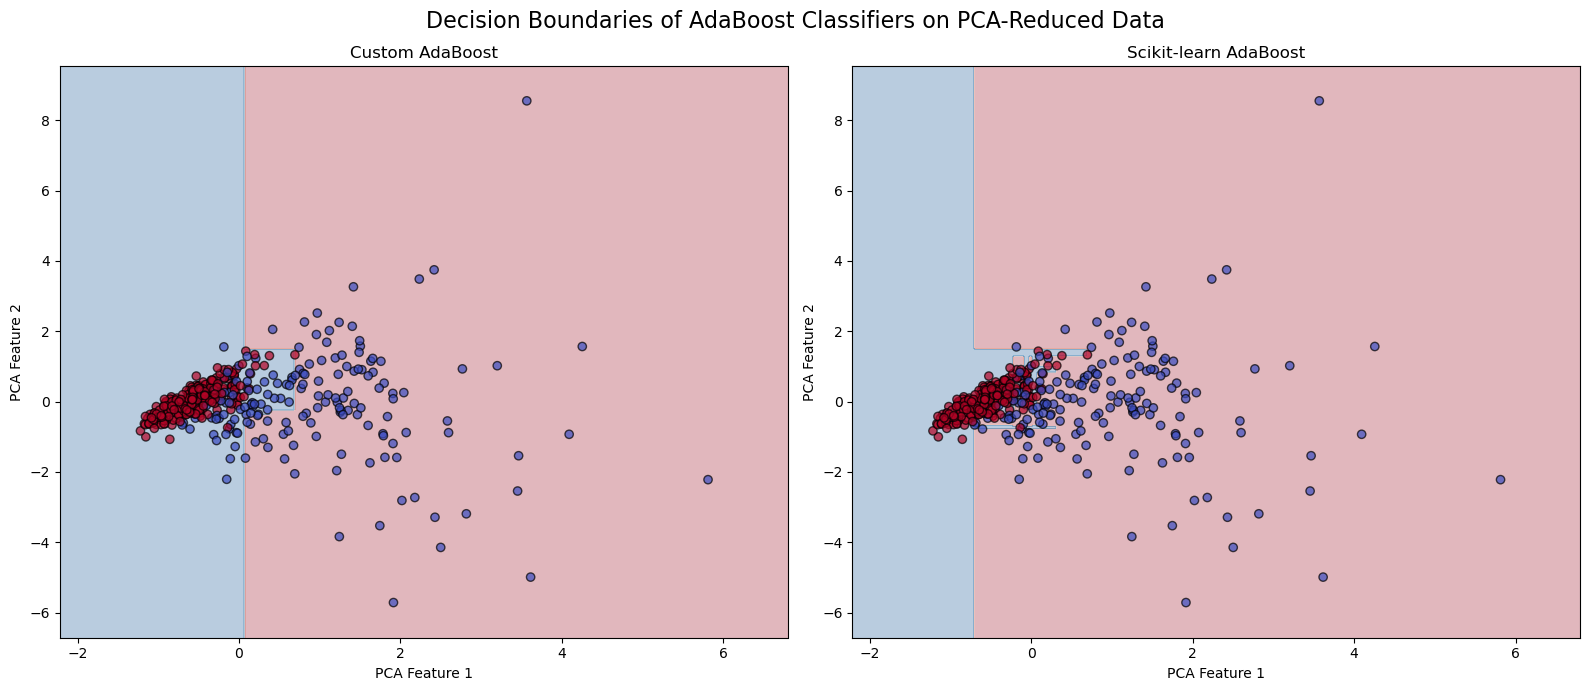

In [28]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Scale the PCA-reduced data
scaler = StandardScaler()
X_train_pca_scaled = scaler.fit_transform(X_train_pca)
X_test_pca_scaled = scaler.transform(X_test_pca)

# Train models on PCA-transformed data
custom_model_pca = CustomAdaBoost(n_estimators=50)
custom_model_pca.fit(X_train_pca_scaled, y_train)

sklearn_model_pca = AdaBoostClassifier(n_estimators=50, random_state=42)
sklearn_model_pca.fit(X_train_pca_scaled, y_train)

titles = ['Custom AdaBoost', 'Scikit-learn AdaBoost']

# Create a mesh grid to visualize the decision boundaries
x_min, x_max = X_train_pca_scaled[:, 0].min() - 1, X_train_pca_scaled[:, 0].max() + 1
y_min, y_max = X_train_pca_scaled[:, 1].min() - 1, X_train_pca_scaled[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))

# Set up figure for visualization
plt.figure(figsize=(16, 7))

# Define colors for visualization
cmap = plt.cm.RdBu
cmap_points = plt.cm.coolwarm

# Loop through classifiers
for i, (clf, title) in enumerate(zip([custom_model_pca, sklearn_model_pca], titles)):
    plt.subplot(1, 2, i + 1)
    
    # Plot the decision boundary
    if hasattr(clf, 'predict'):
        mesh_points = np.c_[xx.ravel(), yy.ravel()]
        Z = clf.predict(mesh_points)
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, alpha=0.3, cmap=cmap)
    
    # Plot the training points
    plt.scatter(X_train_pca_scaled[:, 0], X_train_pca_scaled[:, 1], c=y_train, 
                cmap=cmap_points, edgecolors='k', alpha=0.7)
    
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(title)
    plt.xlabel('PCA Feature 1')
    plt.ylabel('PCA Feature 2')

plt.tight_layout()
plt.suptitle('Decision Boundaries of AdaBoost Classifiers on PCA-Reduced Data', fontsize=16)
plt.subplots_adjust(top=0.9)
plt.show()